# Configurations

### Params

In [2]:
is_skip = True

# Data params
encode_len = 30
pred_len = 7
batch_size = 16

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0.1
num_layers = 4

### Import

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

import torch
from pytorch_model_summary import summary

# Data

### Read

In [3]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})

    df_trans_sample = df_trans.iloc[:10000]

### Preprocess

In [4]:
def preprocess(data):
    data = data.copy()

   # Make sales and mean price
    data = data.groupby(["t_dat", "article_id"], as_index=False).agg(sales=("customer_id", "count"))

   # Expand dates
    # Expand
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    # Fill missings
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["sales"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")

   # Temporal informations
    data["year"] = data["t_dat"].dt.year - data["t_dat"].dt.year.min()
    data["month"] = data["t_dat"].dt.month
    data["dayofweek"] = data["t_dat"].dt.dayofweek
    data["day"] = data["t_dat"].dt.day

    # Cyclic transformation
    def append_cyclic(col, cycle):
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col]/cycle)
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col]/cycle)
    
    append_cyclic("month", 12)
    append_cyclic("dayofweek", 7)
    append_cyclic("day", 365)
    data["year"] = data["year"] - data["year"].min()

   # Aggregate to list
    data = data.groupby(["article_id"], as_index=False)[["sales", "year", "month_sin", "month_cos", "dayofweek_sin", "dayofweek_cos", "day_sin", "day_cos"]].agg(list)
    return data.reset_index(drop=True)

if not is_skip:
    df_prep = preprocess(df_trans)
    df_prep.to_parquet("df_prep.pq")

### Dataset

In [5]:
df_prep = pd.read_parquet("df_prep.pq")
df_prep["article_id"].unique()

array(['0108775015', '0108775044', '0108775051', ..., '0953450001',
       '0953763001', '0956217002'], dtype=object)

In [6]:
df_prep = df_prep[df_prep["article_id"].isin(["0108775015", "0108775044", "0108775051"])].copy()

# Filter
df_prep["size"] = df_prep["sales"].str.len()
df_prep = df_prep[df_prep["size"] >= encode_len + pred_len]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, encode_len, pred_len):
        # Define parameters
        self.encode_len, self.pred_len = encode_len, pred_len
        self.sales_li, self.temporal_li, self.scaler_li = [], [], []
        
        # Iterate rows
        for _, row in tqdm(data.iterrows()):
           # Scale by each article
            # Sales
            scaler = StandardScaler()
            sales = np.array(row["sales"])
            sales = np.log1p(sales)

            # Year
            scaler_ = StandardScaler()
            year = np.array(row["year"])
            year = scaler_.fit_transform(year.reshape(-1,1)).reshape(-1)

           # Unfold
            # Sales
            sales = torch.FloatTensor(sales).unfold(0, encode_len+pred_len, 1)

            # Temporal
            year = torch.FloatTensor(year).unfold(0, encode_len+pred_len, 1)
            month_sin = torch.FloatTensor(row["month_sin"].copy()).unfold(0, encode_len+pred_len, 1)
            month_cos = torch.FloatTensor(row["month_cos"].copy()).unfold(0, encode_len+pred_len, 1)
            dayofweek_sin = torch.FloatTensor(row["dayofweek_sin"].copy()).unfold(0, encode_len+pred_len, 1)
            dayofweek_cos = torch.FloatTensor(row["dayofweek_cos"].copy()).unfold(0, encode_len+pred_len, 1)
            day_sin = torch.FloatTensor(row["day_sin"].copy()).unfold(0, encode_len+pred_len, 1)
            day_cos = torch.FloatTensor(row["day_cos"].copy()).unfold(0, encode_len+pred_len, 1)

            temporal = torch.stack([year, month_sin, month_cos, dayofweek_sin, dayofweek_cos, day_sin, day_cos], dim=-1)

        #    # Filter non-zero
        #     nonzero_idx1 = np.where(sales[:, :-pred_len].sum(axis=-1) > 0)[0] # At least one non-zero from sales X
        #     nonzero_idx2 = np.where(sales[:, -pred_len:].sum(axis=-1) > 0)[0] # At least one non-zero from sales y
        #     nonzero_idx = list(set(nonzero_idx1).intersection(set(nonzero_idx2))) # And condition (intersection)

            # Append to list
            self.sales_li.append(sales)
            self.temporal_li.append(temporal)
        
        # List to tensors
        self.sales_li = torch.concat(self.sales_li)
        self.temporal_li = torch.concat(self.temporal_li)
    
    def __len__(self):
        return self.sales_li.shape[0]
    
    def __getitem__(self, idx):
        # Slice by index
        sales = self.sales_li[idx]
        temporal = self.temporal_li[idx]

        # Split decoder input and output
        encoder_input = sales[:self.encode_len].unsqueeze(-1)
        y = sales[-self.pred_len:].unsqueeze(-1)

        return encoder_input, y, temporal

dataset = Dataset(df_prep, encode_len, pred_len)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for data in dataloader:
    encoder_input, y, temporal = data
    print("encoder_input:", encoder_input.shape)
    print("y:", y.shape)
    print("temporal:", temporal.shape)
    break

0it [00:00, ?it/s]

3it [00:00, 91.96it/s]

encoder_input: torch.Size([16, 30, 1])
y: torch.Size([16, 7, 1])
temporal: torch.Size([16, 37, 7])


# Architecture

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, num_layers):
        super().__init__()
        self.temporal_encoder = torch.nn.Linear(7, d_model)

        # Encoder
        self.sales_encoder = torch.nn.Linear(1, d_model)
        self.encoder_layernorm = torch.nn.LayerNorm(d_model)
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), nhead)

        # Decoder
        self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), nhead)
        self.decoder_output_layer = torch.nn.Linear(d_model, 2)
    
    def forward(self, encoder_input, temporal, encode_len, pred_len):
        # Get temporal encoded sales
        temporal_encoding = torch.nn.ReLU()(self.temporal_encoder(temporal))
        encoder_temporal = temporal_encoding[:, :encode_len, :]
        decoder_temporal = temporal_encoding[:, -pred_len:, :]

        # Encoder
        encoder_input = self.encoder_layernorm(torch.nn.ReLU()(self.sales_encoder(encoder_input)) + encoder_temporal)
        encoder_output = self.encoder(encoder_input)

        # Decoder
        decoder_output = self.decoder(tgt=decoder_temporal, memory=encoder_output+encoder_temporal)
        output = self.decoder_output_layer(decoder_output)
        return output


model = Transformer(d_model, nhead, d_ff, dropout, num_layers)

summary(model, 
        encoder_input[0].unsqueeze(0),
        temporal[0].unsqueeze(0),
        encode_len, pred_len, 
        show_parent_layers=True, # show_hierarchical=True,
        print_summary=True
        )

--------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #
     Transformer                Linear-1        [1, 37, 128]           1,024           1,024
     Transformer                Linear-2        [1, 30, 128]             256             256
     Transformer             LayerNorm-3        [1, 30, 128]             256             256
     Transformer    TransformerEncoder-4        [1, 30, 128]         529,920         529,920
     Transformer    TransformerDecoder-5         [1, 7, 128]         795,136         795,136
     Transformer                Linear-6           [1, 7, 2]             258             258
Total params: 1,326,850
Trainable params: 1,326,850
Non-trainable params: 0
--------------------------------------------------------------------------------------------


'--------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #\n============================================================================================\n     Transformer                Linear-1        [1, 37, 128]           1,024           1,024\n     Transformer                Linear-2        [1, 30, 128]             256             256\n     Transformer             LayerNorm-3        [1, 30, 128]             256             256\n     Transformer    TransformerEncoder-4        [1, 30, 128]         529,920         529,920\n     Transformer    TransformerDecoder-5         [1, 7, 128]         795,136         795,136\n     Transformer                Linear-6           [1, 7, 2]             258             258\n============================================================================================\nTotal params: 1,326,850\nTrainable params: 1,326,850\nNon-t

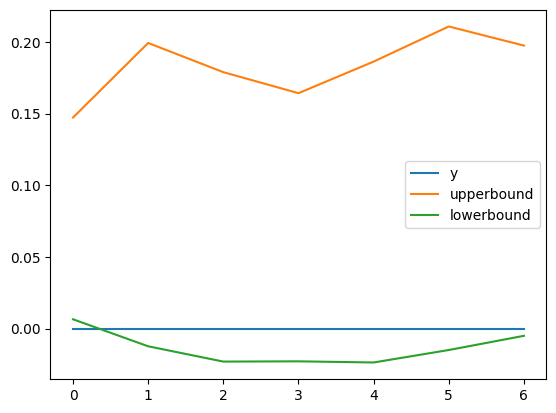

In [8]:
import time
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss_fn = torch.nn.MSELoss()
window = 20

def loss_fn(upperbound, lowerbound, y):
    outside_interval = torch.max(y - upperbound, torch.zeros(y.shape)) + torch.max(lowerbound - y, torch.zeros(y.shape))
    interval_width = upperbound - lowerbound
    interval_penalty = 0.1 * interval_width
    loss = torch.mean(outside_interval + interval_penalty)
    # time.sleep(0.5)
    
    return loss

def plot_sample(y, upperbound, lowerbound):
    clear_output(wait=True)
    plt.plot(y[0].squeeze(-1), label="y")
    plt.plot(upperbound[0].detach().numpy().squeeze(-1), label="upperbound")
    plt.plot(lowerbound[0].detach().numpy().squeeze(-1), label="lowerbound")
    plt.legend()
    plt.show()

def train(e):
    model.train()
    loss_li = []
    pbar = tqdm(dataloader)
    for n, data in enumerate(pbar):
        encoder_input, y, temporal = data

        # Train
        optimizer.zero_grad()
        pred = model(encoder_input, temporal, encode_len, pred_len)
        upperbound = pred[:, :, 0:1]
        lowerbound = pred[:, :, -1:]
        loss = loss_fn(upperbound, lowerbound, y)
        loss.backward()
        optimizer.step()

        # Report
        loss_li.append(loss.item())
        pbar.set_description(f'epoch{e} - loss: {np.round(np.mean(loss_li[-window:]), 5)}')
        plot_sample(torch.expm1(y), torch.expm1(upperbound), torch.expm1(lowerbound))
        if n % 100 == 0:
            input()

epoch = 10
for e in range(epoch):
    train(e)